*Exercise: Key Performance Indicators (KPIs): Define three time-dependent KPIs that you would include in
 a dashboard for the hub operator. These KPIs must provide an immediate overview of the current
 hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
 explain the rationale behind selecting each KPI, explain why you have chosen it and, where
 needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
 time. Which trends do you observe? How do you explain them?*
 

1. **Total Drawn Power in kW**
This KPI is particularly relevant for monitoring energy load and therefore probably the main source of costs for the site. If the operator knows his electricity costs, he can also use this KPI to make further economic calculations. Consumption transparency also enables choosing the most suitable energy supplier or contemplating about pricing measures such as dynamic pricing. Another interesting idea could be to assess the integration of on-site renewable energy technologies, e.g. solar panels, to offset peak energy costs.

2. **Active Sessions**
This basic KPI is helpful in identifying peak and minimum utilization times, which could for example support decisions toward a novel pricing rationale. An early identification of trends with this KPI also supports well-funded long term decisions. Additionally, comparisons between the two sites allow the evaluation of different characteristics of those.

3. **Idle Rate**
This KPI uncovers another aspect of running an EV charging site, which is handling EVs that block stations but are not charging. If the operator can for example identify times in which both utilization rate and idle rate are high, they can consider measures against EVs blocking the station after being fully charged, like penalties, time-sensitive fees, or shorter maximum session durations.

The first three plots are suitable for inclusion in a dashboard for the hub operator. They provide an immediate overview of the current hub operation. The plots show the hourly values for the selected KPIs and visualize them over time. Please use the function parameter *last_x_hours* as an input to define the number of hours to be considered in the retrospective view. Please note that this view works best for up to 168 hours or one week. 

To look at long-time trends, please scroll down.




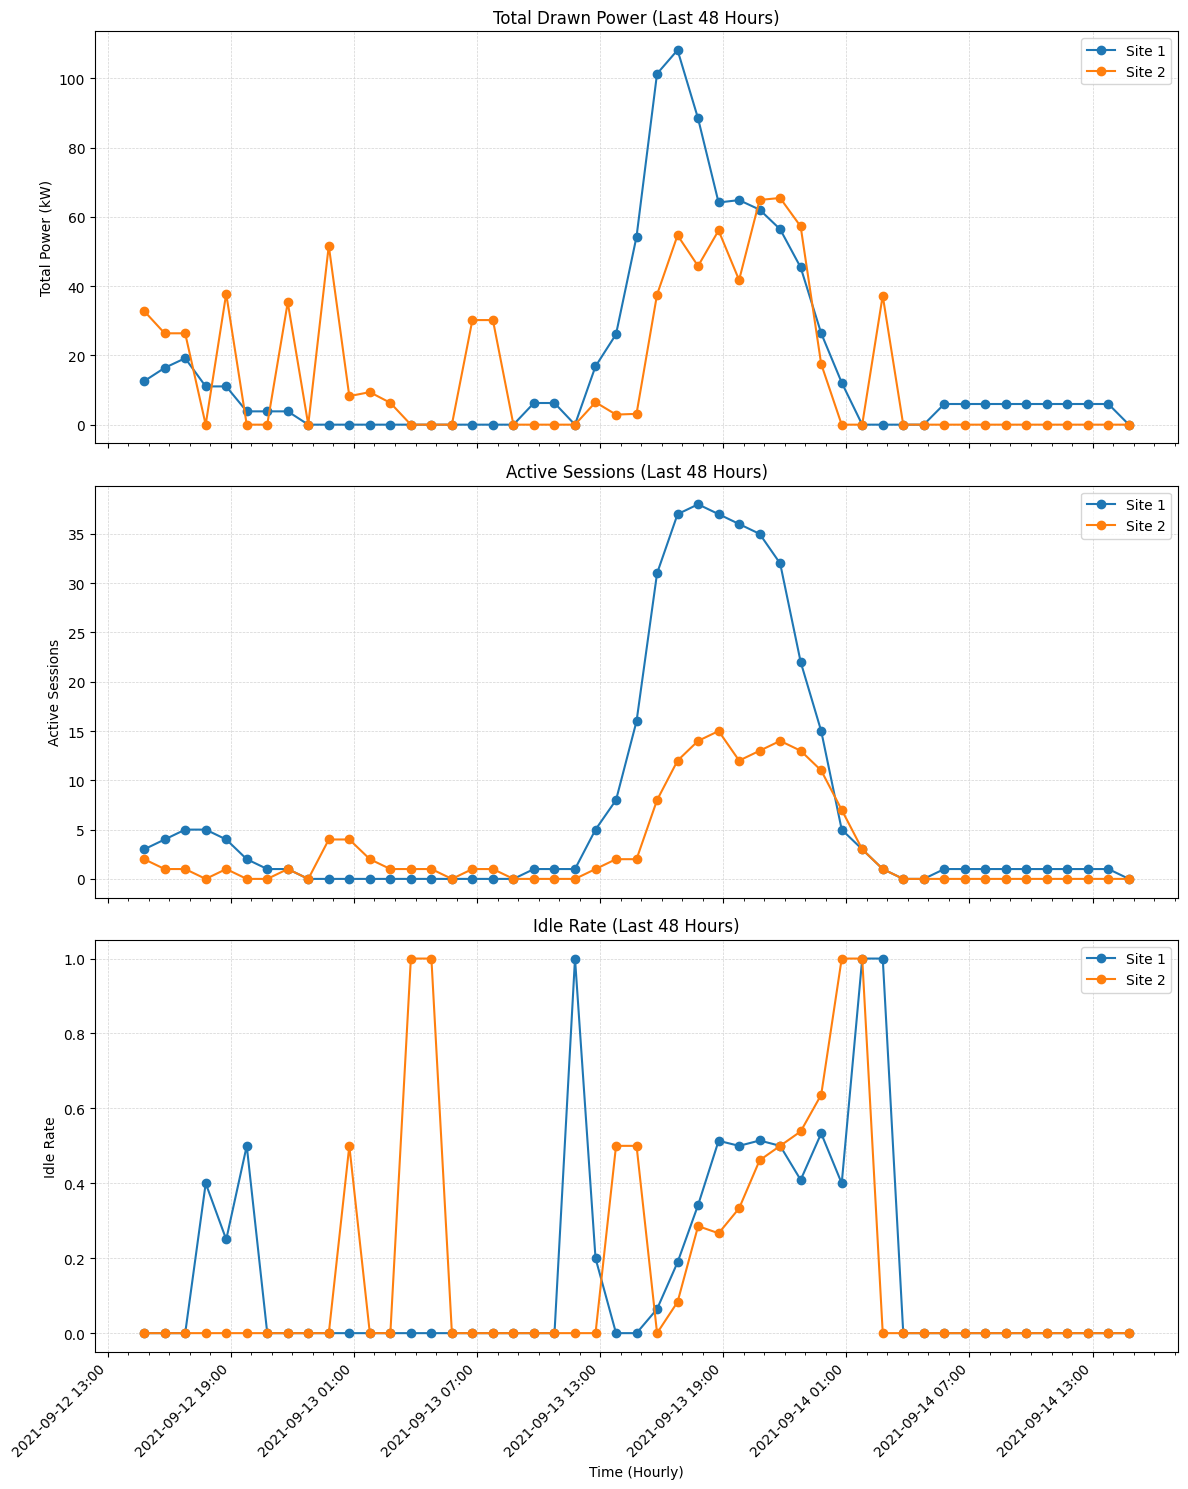

In [8]:
# Wieviele Stunden sollen in der Rückschau betrachtet werden?

def plot_KPIs(last_x_hours: int):
    #imports
    import pandas as pd
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib.dates as mdates
    
    #############################################################################
    #data operations
    df = pd.read_csv('../data/processed/charging_sessions_cleaned.csv')
    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
    # Use disconnectTime as fallback for doneChargingTime
    df.loc[df['doneChargingTime'].isna(), 'doneChargingTime'] = df['disconnectTime'] # is illogical in most cases, here, it is appropriate because for all of these plots, the information about the EV being fully charged is not necessary
    
    #############################################################################
    #conditional compression
    if last_x_hours > 168:
        compression = True
    else:
        compression = False
    
    ###############################################################################
    
    # Determine the last X hours
    end_time_plot_1 = df['doneChargingTime'].max()
    start_time_plot_1 = end_time_plot_1 - pd.Timedelta(hours=last_x_hours)
    
    # Filter sessions occurring in the last 120 hours
    filtered_df_plot_1 = df[
        (df['doneChargingTime'] >= start_time_plot_1) & 
        (df['connectionTime'] <= end_time_plot_1)
    ]
    
    # Create an array to store total charging power for each site and hour
    hours_plot_1 = pd.date_range(start=start_time_plot_1, end=end_time_plot_1, freq='h')
    power_by_site = np.zeros((2, len(hours_plot_1)))
    
    # Loop through the sessions and accumulate power for each hour and site
    for _, row in filtered_df_plot_1.iterrows():
        site_idx = row['siteID'] - 1  # Assuming siteID is 1 or 2
        for i, hour in enumerate(hours_plot_1):
            if row['connectionTime'] <= hour and row['doneChargingTime'] > hour:
                power_by_site[site_idx, i] += row['chargingPower']
    
    #conditional compression
    if compression:
        
        while (power_by_site.shape[1] % 3 != 0):
            power_by_site = power_by_site[:, 1:]
            start_time_plot_1 += pd.Timedelta(hours=1)
        
        binned_power_by_site = power_by_site.reshape(2, -1, 3).mean(axis=2)
        power_by_site = binned_power_by_site
        
        binned_hours_plot_1= pd.date_range(
            start=start_time_plot_1, 
            end=end_time_plot_1, 
            freq='3h'
        )
        hours_plot_1 = binned_hours_plot_1
    
    ###############################################################################
    
    # Filter for the last x hours
    end_time_plot_2 = df['disconnectTime'].max()
    start_time_plot_2 = end_time_plot_2 - pd.Timedelta(hours=last_x_hours)
    
    filtered_df_plot_2 = df[
        (df['disconnectTime'] >= start_time_plot_2) & 
        (df['connectionTime'] <= end_time_plot_2)
    ]
    
    # Calculate total available stations per site
    total_stations_per_site = filtered_df_plot_2.groupby('siteID')['stationID'].nunique()
    
    # Create an array to store active sessions for each site and hour
    hours = pd.date_range(start=start_time_plot_2, end=end_time_plot_2, freq='h')
    active_sessions = np.zeros((2, len(hours)))
    
    # Loop through the sessions and calculate Active Sessions for each hour and site
    for i, hour in enumerate(hours):
        for site in [1, 2]:
            # Filter active sessions for the current site and hour
            active_sessions_plot_2 = filtered_df_plot_2[
                (filtered_df_plot_2['siteID'] == site) &
                (filtered_df_plot_2['connectionTime'] <= hour) &
                (filtered_df_plot_2['disconnectTime'] > hour)
            ]
            # Calculate active sessions
            num_active_sessions = len(active_sessions_plot_2)
            active_sessions[site - 1, i] = num_active_sessions
    
    #conditional compression
    if compression:
        
        while (active_sessions.shape[1] % 3 != 0):
            active_sessions = active_sessions[:, 1:] 
            start_time_plot_2 += pd.Timedelta(hours=1)
        
        binned_active_sessions = active_sessions.reshape(2, -1, 3).mean(axis=2)
        active_sessions = binned_active_sessions
        
        binned_hours = pd.date_range(
            start=start_time_plot_2, 
            end=end_time_plot_2, 
            freq='3h'
        )
        hours = binned_hours #binning is done when calculating idle rates

            
    ###############################################################################
    
    # Filter for the last x hours
    end_time_plot_3 = df['disconnectTime'].max()
    start_time_plot_3 = end_time_plot_3 - pd.Timedelta(hours=last_x_hours)
    
    filtered_df_plot_3 = df[
        (df['disconnectTime'] >= start_time_plot_3) & 
        (df['connectionTime'] <= end_time_plot_3)
    ]
    
    # Create an array to store idle rates for each site and hour
    hours = pd.date_range(start=start_time_plot_3, end=end_time_plot_3, freq='h')
    idle_rates = np.zeros((2, len(hours)))
    
    # Loop through each hour and calculate idle rate for each site
    for i, hour in enumerate(hours):
        for site in [1, 2]:
            # Filter sessions for the current site
            site_df = filtered_df_plot_3[filtered_df_plot_3['siteID'] == site]
            
            # Zähler: Number of sessions in idling at that time
            idle_sessions = site_df[
                (site_df['doneChargingTime'] <= hour) &
                (site_df['disconnectTime'] > hour)
            ]
            num_idle_sessions = len(idle_sessions)
            
            # Nenner: Number of all sessions (charging or idling) at that time
            active_sessions_plot_3 = site_df[
                (site_df['connectionTime'] <= hour) &
                (site_df['disconnectTime'] > hour)
            ]
            num_active_sessions = len(active_sessions_plot_3)
            
            # Calculate idle rate (handle edge case of no active sessions)
            if num_active_sessions > 0:
                idle_rates[site - 1, i] = num_idle_sessions / num_active_sessions
            else:
                idle_rates[site - 1, i] = 0
    
    #conditional compression       
    if compression:
        
        while (idle_rates.shape[1] % 3 != 0):
            idle_rates = idle_rates[:, 1:] 
            start_time_plot_3 += pd.Timedelta(hours=1)        
        
        binned_idle_rates = idle_rates.reshape(2, -1, 3).mean(axis=2)
        idle_rates = binned_idle_rates
        
        binned_hours = pd.date_range(
            start=start_time_plot_3, 
            end=end_time_plot_3, 
            freq='3h'
        )
        hours = binned_hours    
                
    ###############################################################################
    # Plotting
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    #Total Drawn Power
    axes[0].plot(hours_plot_1, power_by_site[0], label='Site 1', linestyle='-', marker='o')
    axes[0].plot(hours_plot_1, power_by_site[1], label='Site 2', linestyle='-', marker='o')
    axes[0].set_title('Total Drawn Power (Last ' + str(last_x_hours) + ' Hours)')
    axes[0].set_ylabel('Total Power (kW)')
    axes[0].legend()
    axes[0].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #Active Sessions
    axes[1].plot(hours, active_sessions[0], label='Site 1', linestyle='-', marker='o')
    axes[1].plot(hours, active_sessions[1], label='Site 2', linestyle='-', marker='o')
    axes[1].set_title('Active Sessions (Last ' + str(last_x_hours) + ' Hours)')
    axes[1].set_ylabel('Active Sessions')
    axes[1].legend()
    axes[1].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #idle rate
    axes[2].plot(hours, idle_rates[0], label='Site 1', linestyle='-', marker='o')
    axes[2].plot(hours, idle_rates[1], label='Site 2', linestyle='-', marker='o')
    axes[2].set_title('Idle Rate (Last ' + str(last_x_hours) + ' Hours)')
    axes[2].set_xlabel('Time (Hourly)')
    axes[2].set_ylabel('Idle Rate')
    axes[2].legend()
    axes[2].grid(color='lightgray', linestyle='--', linewidth=0.5)
    
    #x-axis ticks
    if last_x_hours <= 300:
        axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Major ticks every 6 hours
    else:
        axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Major ticks every 12 hours
    axes[2].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every 1 hour
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format for major ticks
    
    #Rotate x labels
    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
  
plot_KPIs(last_x_hours = 48)

**Long-Term Retrospect**\
The developments of the three KPIs over a longer period of time are shown below. Please use the toggle function of the plots' legends to display selectively.

**Trend**\
Regarding the structure and distribution of the data, we can see that the series is relatively stable in magnitude and pattern at the beginning. We can then see that there was an abrupt drop in activity in April 2020, which has been slowly recovering ever since. This is probably due to the Covid-19 pandemic, during which many people stayed at home and thus a general reduction in the use of public charging infrastructure seems reasonable.
Since then, there has been a clear upward trend in both active sessions and total drawn power, which is not surprising given the relationship between the two figures. The period of missing data around October 2020, which lasted several months, is difficult to interpret. This could be due to the closure of the sites, but also to a lack of measurements for other reasons.\
Either way, this does not detract from the observable trend. For site 1, mean active sessions (on working days) have risen from under five to almost 20 until the end of the dataset's time frame. In relative terms, site 2 has also undergone a similar development, only here the general level is significantly lower, which also applies to total drawn power. The reasons for this might be a combination of the generally increasing market penetration of EVs in the western USA and post-Covid-19 recovery. Logically, the maximum values are also increasingly approaching the pre-Covid level.


**Idle Rate**\
As far as the idle rate is concerned, the long-term view shows that this KPI is particularly interesting in the short-term view. No significant trend can be identified here.

In [59]:
def plot_KPIs_interactive(last_x_days: int):
    import plotly.graph_objects as go
    import pandas as pd
    
    # Load the data
    aggregated_data = pd.read_csv("../data/processed/daily_avg_min_max_KPIs.csv")

    # Parse day column to datetime
    aggregated_data['day'] = pd.to_datetime(aggregated_data['day'])

    end_date = aggregated_data['day'].max()
    start_date = end_date - pd.Timedelta(days=last_x_days)
    aggregated_data = aggregated_data[aggregated_data['day'] >= start_date]


    #############################################################################
    #PLOT ACTIVE SESSIONS

    # Set up the figure
    fig = go.Figure()

    # Plot for site 1: Active Sessions
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_1_min'],
        mode='lines',
        line=dict(color='blue', width=0),
        name='Site 1: Active Sessions (Min)',
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_1_max'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.3)',
        line=dict(color='blue', width=0),
        name='Site 1: Active Sessions (Min-Max Corridor)',
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_1_mean'],
        mode='lines',
        name='Site 1: Active Sessions (Mean)',
        line=dict(color='blue')
    ))

    # Plot for site 2: Active Sessions
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_2_min'],
        mode='lines',
        line=dict(color='orange', width=0),
        name='Site 2: Active Sessions (Min)',
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_2_max'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(255, 165, 0, 0.3)',
        line=dict(color='orange', width=0),
        name='Site 2: Active Sessions (Min-Max Corridor)',
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['activeSessions_site_2_mean'],
        mode='lines',
        name='Site 2: Active Sessions (Mean)',
        line=dict(color='orange')
    ))

    # Update layout for interactivity and style
    fig.update_layout(
        title="Interactive Active Sessions Plot",
        xaxis_title="Time (daily averages and peaks)",
        yaxis_title="Active Sessions",
        legend_title="Legend (Click to toggle lines)",
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(gridcolor='rgba(128, 128, 128, 0.2)'),
        yaxis=dict(gridcolor='rgba(128, 128, 128, 0.2)')
    )

    # Show the figure
    fig.show()
    
    #############################################################################
    #PLOT TOTAL DRAWN POWER
    
    # Set up the figure
    fig = go.Figure()

    # Plot for site 1: Total Drawn Power
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_1_min'],
        mode='lines',
        line=dict(color='blue', width=0),
        name='Site 1: Total Drawn Power (min)',
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_1_max'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.3)',
        line=dict(color='blue', width=0),
        name='Site 1: Total Drawn Power (Min-Max Corridor)',
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_1_mean'],
        mode='lines',
        name='Site 1: Total Drawn Power (Mean)',
        line=dict(color='blue')
    ))

    # Plot for site 2: Total Drawn Power
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_2_min'],
        mode='lines',
        line=dict(color='orange', width=0),
        name='Site 2: Total Drawn Power (Min)',
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_2_max'],
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(255, 165, 0, 0.3)',
        line=dict(color='orange', width=0),
        name='Site 2: Total Drawn Power (Min-Max Corridor)',
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=aggregated_data['day'], 
        y=aggregated_data['total_drawn_power_2_mean'],
        mode='lines',
        name='Site 2: Total Drawn Power (Mean)',
        line=dict(color='orange')
    ))

    # Update layout for interactivity and style
    fig.update_layout(
        title="Interactive Total Drawn Power Plot",
        xaxis_title="Time (daily averages and peaks)",
        yaxis_title="Total Drawn Power (kW)",
        legend_title="Legend (Click to toggle lines)",
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(gridcolor='rgba(128, 128, 128, 0.2)'),
        yaxis=dict(gridcolor='rgba(128, 128, 128, 0.2)', range=[0, 200])
    )

    # Show the figure
    fig.show()
    
plot_KPIs_interactive(750)
